In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp



In [ ]:

class JohnnyBot:

    def __init__(self) -> None:
        self.control =  jnp.array([.1,0])
        self.goalstate = jnp.array([0,0,0,0])
        self.initstate = jnp.array([2, 2,0,0])
        self.dt = 0.05
        self.t_span = (0, 20)
        self.kv = .1
        self.kw = 1.5
        self.maxspeed = 2
        self.arrowsize = .02
        self.arrow_step = 100

        pass
        
    def basic_controller(self, state):
        # Current state: [x, y, theta, v]
        x, y, theta, v = state
        x_goal, y_goal, theta_goal, _ = self.goalstate

        # Compute position error
        dx = x_goal - x
        dy = y_goal - y
        distance_to_goal = jnp.sqrt(dx**2 + dy**2)

        # Desired heading angle to the goal
        desired_heading = jnp.arctan2(dy, dx)

        # Orientation error
        heading_error = desired_heading - theta
        # Normalize heading_error to [-pi, pi]
        heading_error = (heading_error + jnp.pi) % (2*jnp.pi) - jnp.pi

        # Linear velocity command: proportional to distance, capped by maxspeed
        v_cmd = self.kv * distance_to_goal
        v_cmd = jnp.clip(v_cmd, -self.maxspeed, self.maxspeed)
       # if heading_error > np.pi/4 or heading_error < -np.pi/4:
        #    v_cmd = 0 

        # Angular velocity command: proportional to heading error
        w_cmd = self.kw * heading_error

        

        # Set control input
        # Format: [angular_velocity, linear_velocity]
        self.control = jnp.array([w_cmd, v_cmd])

    def state_derivative(self,t, state):

        '''
        Computes x_dot where x_dot = f(x, u)
        Inputs:
            state     : A jax.numpy array of size (n,) x
            control   : A jax.numpy array of size (m,) u 

        Output:
            state_derivative : A jax.numpy array of size (n,)
        '''

        
        # Extracting important values from state vector 
        self.basic_controller(state)

        theta_dot = self.control[0]
        v_dot     = self.control[1]
        theta =state[2]
        v = v_dot
         
        
        # Computing deriviatives of state vector
        x_dot = v*jnp.cos(theta)
        y_dot = v*jnp.sin(theta)
       
        
        # Constructing derivative vector of state 
        X_dot = jnp.array([x_dot, y_dot, theta_dot, v_dot])
        state_derivative = X_dot

        return state_derivative
    
    def plotTraj(self, sol):
        # Extract the results
        t = sol.t
        state = sol.y

        # Plotting the position trajectory
        plt.figure(figsize=(5,5))
        # Add arrows to show orientation
        
        for i in range(0, len(t), self.arrow_step):
            dx = np.cos(state[2,i]) * 0.5  # Scale the arrow length
            dy = np.sin(state[2,i]) * 0.5
            plt.arrow(state[0,i], state[1,i], dx, dy, head_width=self.arrowsize, head_length=self.arrowsize, color="red")

        # Mark the start position
        plt.scatter(state[0,0], state[1,0], color="green", label="Start")


        # Mark the goal position if provided
        x_goal, y_goal, _, _ = self.goalstate
        plt.scatter(x_goal, y_goal, color="red", label="Goal")
        plt.plot(state[0,:], state[1,:], 'b-', label='Trajectory')
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.title('Trajectory')
        plt.legend()
        plt.grid(True)
        plt.axis('equal')
        plt.show()

    def plotXY(self, sol):
        t = sol.t
        state = sol.y
        
        plt.figure(figsize=(15,4))
        plt.subplot(1,2,1)

        plt.plot(t, state[0,:], 'b-', label='Trajectory')
        plt.xlabel('time  (sec)')
        plt.ylabel('X Position')
        plt.title('X position over time')
        plt.legend()
        plt.grid(True)
        plt.axis('equal')

        plt.subplot(1,2,2)
        plt.plot(t, state[1,:], 'b-', label='Trajectory')
        plt.xlabel('time (sec)')
        plt.ylabel('Y Position')
        plt.title('Y position over time')
        plt.legend()
        plt.grid(True)
        plt.axis('equal')
        plt.show()
    

    # turn into sim sector when there is more than one 
    def runsim(self):
        sol = solve_ivp(self.state_derivative, self.t_span, self.initstate, max_step=self.dt)
        self.plotTraj(sol)
        self.plotXY(sol)


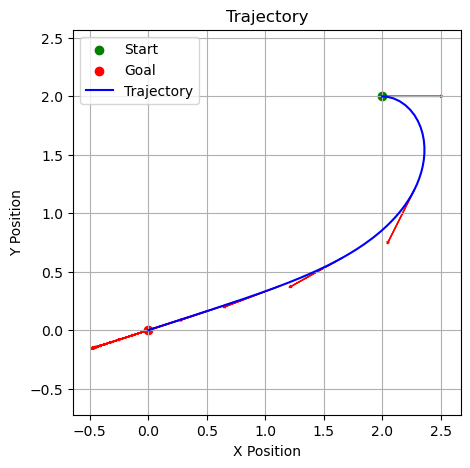

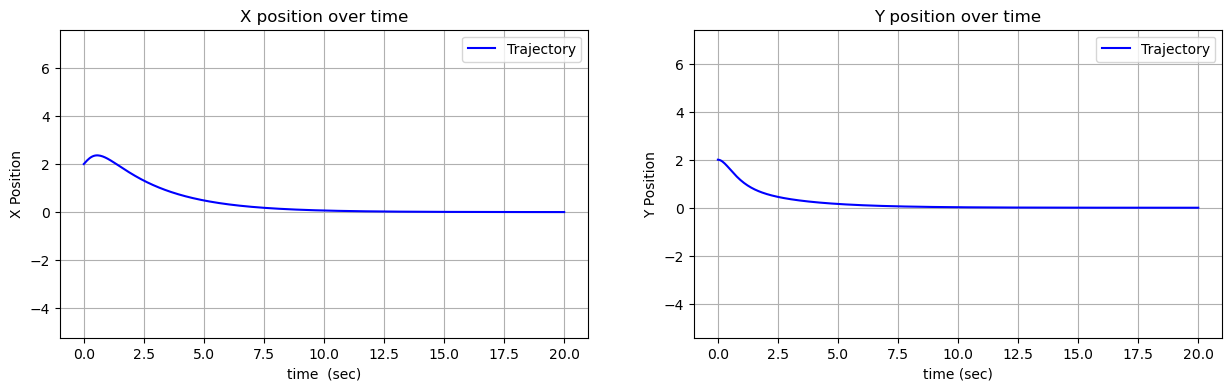

In [ ]:
# test case
BotA = JohnnyBot()
BotA.dt = 0.05
BotA.kv = .4
BotA.kw = 1.8
BotA.arrow_step = 20
BotA.t_span = (0, 20)   # simulation time span

BotA.runsim()

